##**Step 1: Load and Inspect the Dataset**

In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv("predictive_maintenance_dataset.csv")

# Display the first few rows
df.head()

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
0,1/1/2015,S1F01085,0,215630672,55,0,52,6,407438,0,0,7
1,1/1/2015,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,1/1/2015,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,1/1/2015,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,1/1/2015,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


##**Step 2: Inspect the Dataset Structure**

Before performing any analysis, check basic details like the number of rows, columns, and data types.

In [2]:
# Print structure and data types
print("Dataset shape:", df.shape)
print("\nDataset info:")
print(df.info())

# Show summary statistics
print("\nSummary statistics:")
print(df.describe())

Dataset shape: (124494, 12)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 12 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   date     124494 non-null  object
 1   device   124494 non-null  object
 2   failure  124494 non-null  int64 
 3   metric1  124494 non-null  int64 
 4   metric2  124494 non-null  int64 
 5   metric3  124494 non-null  int64 
 6   metric4  124494 non-null  int64 
 7   metric5  124494 non-null  int64 
 8   metric6  124494 non-null  int64 
 9   metric7  124494 non-null  int64 
 10  metric8  124494 non-null  int64 
 11  metric9  124494 non-null  int64 
dtypes: int64(10), object(2)
memory usage: 11.4+ MB
None

Summary statistics:
             failure       metric1        metric2        metric3  \
count  124494.000000  1.244940e+05  124494.000000  124494.000000   
mean        0.000851  1.223881e+08     159.492706       9.940897   
std         0.029167  7.045933e+

## **Step 3: Convert the Date Column**

In [3]:
# Convert 'date' column to datetime format (with error handling)
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Confirm the conversion
print(df['date'].head())

0   2015-01-01
1   2015-01-01
2   2015-01-01
3   2015-01-01
4   2015-01-01
Name: date, dtype: datetime64[ns]


## **Step 4: Check for Missing Values**


In [4]:
# Check for missing values in each column
missing_counts = df.isnull().sum()

# Print the result
print("Missing values per column:\n", missing_counts)

# Check if the entire dataset is clean
if missing_counts.sum() == 0:
    print("\n The dataset is clean — no missing values found.")
else:
    print("\n Some columns contain missing values. Further handling is required.")

Missing values per column:
 date       0
device     0
failure    0
metric1    0
metric2    0
metric3    0
metric4    0
metric5    0
metric6    0
metric7    0
metric8    0
metric9    0
dtype: int64

 The dataset is clean — no missing values found.


##**Step 5: Outlier Detection and Treatments**


1.   Visualize outliers using boxplots.
2.   Treat outliers using the IQR method (you’ll choose whether to remove or cap them).



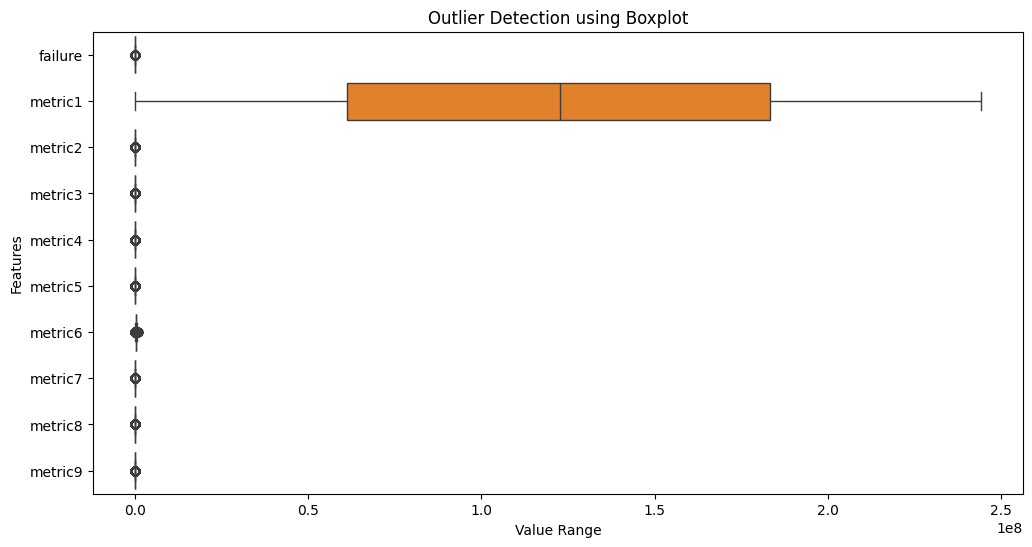

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot size
plt.figure(figsize=(12, 6))

# Create a horizontal boxplot for all numerical features
sns.boxplot(data=df.select_dtypes(include=['float64', 'int64']), orient='h')

plt.title("Outlier Detection using Boxplot")
plt.xlabel("Value Range")
plt.ylabel("Features")
plt.show()

In [6]:
# Function to cap outliers using the IQR method
def cap_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[column] = df[column].clip(lower, upper)

# Apply to all numeric features except 'failure'
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
numeric_cols = [col for col in numeric_cols if col != 'failure']

for col in numeric_cols:
    cap_outliers(df, col)

print("Outliers capped for metric1–metric9 using the IQR method.")

Outliers capped for metric1–metric9 using the IQR method.


## **Step 6: Feature Engineering**

In this step, we’ll create new informative features to help models detect patterns better:


1.   Extract Features from the date Column (year, month, day, and weekday)
2.   Split the device Column into sector and equipment



In [7]:
# Extract time-based features from 'date'
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.weekday  # 0 = Monday, 6 = Sunday

print("Extracted 'year', 'month', 'day', and 'weekday' from 'date'.")

Extracted 'year', 'month', 'day', and 'weekday' from 'date'.


In [8]:
# Split 'device' column into 'sector' and 'equipment'
df['sector'] = df['device'].str[:4]       # First 4 characters
df['equipment'] = df['device'].str[4:]    # Remaining characters

print("Extracted 'sector' and 'equipment' from 'device' column.")

Extracted 'sector' and 'equipment' from 'device' column.



## **Step 7: Encode Categorical Features**
Machine learning models need all features in numeric form, so we’ll encode:


1.   Sector and equipment (from the device column)
2.   Optionally weekday or month if using tree-based models that don't need scaling

In [9]:
from sklearn.preprocessing import LabelEncoder

# Initialize encoder
le = LabelEncoder()

# Encode 'sector' and 'equipment'
df['sector_encoded'] = le.fit_transform(df['sector'])
df['equipment_encoded'] = le.fit_transform(df['equipment'])

print("Applied label encoding to 'sector' and 'equipment'.")

Applied label encoding to 'sector' and 'equipment'.


In [10]:
df.drop(['sector', 'equipment', 'device'], axis=1, inplace=True)

## **Step 8: Scale Numerical Features**

We’ll scale the data using MinMaxScaler to bring all features into the same range.

In [12]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler()

# Select numeric columns (excluding target column 'failure')
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
num_cols = [col for col in num_cols if col != 'failure']

# Apply MinMaxScaler
df[num_cols] = scaler.fit_transform(df[num_cols])

print("Min-Max scaling applied to numerical features.")

Min-Max scaling applied to numerical features.


## **Step 9: Save the Cleaned Dataset**

After cleaning, save the dataset for further analysis.

In [13]:
# Preview the first 10 rows of the cleaned dataset
print(df.head(10))

print("Final dataset shape:", df.shape)
print("\nFinal column names:")
print(df.columns.tolist())

        date  failure   metric1  metric2  metric3  metric4  metric5   metric6  \
0 2015-01-01        0  0.883224      0.0      0.0      0.0   0.2500  0.898527   
1 2015-01-01        0  0.251374      0.0      0.0      0.0   0.2500  0.886524   
2 2015-01-01        0  0.709821      0.0      0.0      0.0   0.6250  0.419875   
3 2015-01-01        0  0.326427      0.0      0.0      0.0   0.2500  0.906262   
4 2015-01-01        0  0.556935      0.0      0.0      0.0   0.8125  0.633183   
5 2015-01-01        0  0.281959      0.0      0.0      0.0   0.2500  0.915689   
6 2015-01-01        0  0.932748      0.0      0.0      0.0   0.3750  0.884697   
7 2015-01-01        0  0.579599      0.0      0.0      0.0   1.0000  1.000000   
8 2015-01-01        0  0.033660      0.0      0.0      0.0   0.7500  0.629512   
9 2015-01-01        0  0.476939      0.0      0.0      0.0   0.4375  0.899841   

   metric7  metric8  metric9  year  month  day  weekday  sector_encoded  \
0      0.0      0.0      0.0  201

In [14]:
# Save the cleaned dataset
df.to_csv("cleaned_dataset_for_modeling.csv", index=False)
print("Cleaned dataset saved as 'cleaned_dataset_for_modeling.csv'")

Cleaned dataset saved as 'cleaned_dataset_for_modeling.csv'
